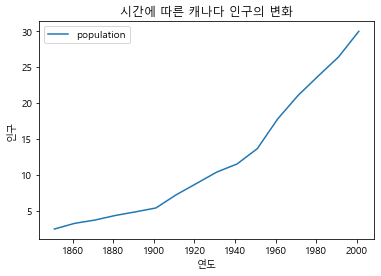

In [17]:
# statsmodels 패키지 활용
import statsmodels.api as sm
import matplotlib.pyplot as plt

# font를 지정하면 한글이 깨지지 않음
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname=r"c:\\Windows\\Fonts\\malgun.ttf").get_name()
rc('font', family=font_name)

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False      # 축 눈금 마이너스 깨지는 문제 해결

# 비정상 확률과정 rdataset 가져오기
# 추세를 가지는 경우. 일차모멘트 즉 기댓값이 시간에 따라 변화함
# 추세가 없지만 분산이 시간에 따라 변하는 경우
df = sm.datasets.get_rdataset("CanPop", package="carData").data
df.plot(x="year", y="population")
plt.xlabel("연도")
plt.ylabel("인구")
plt.title("시간에 따른 캐나다 인구의 변화")
plt.show()

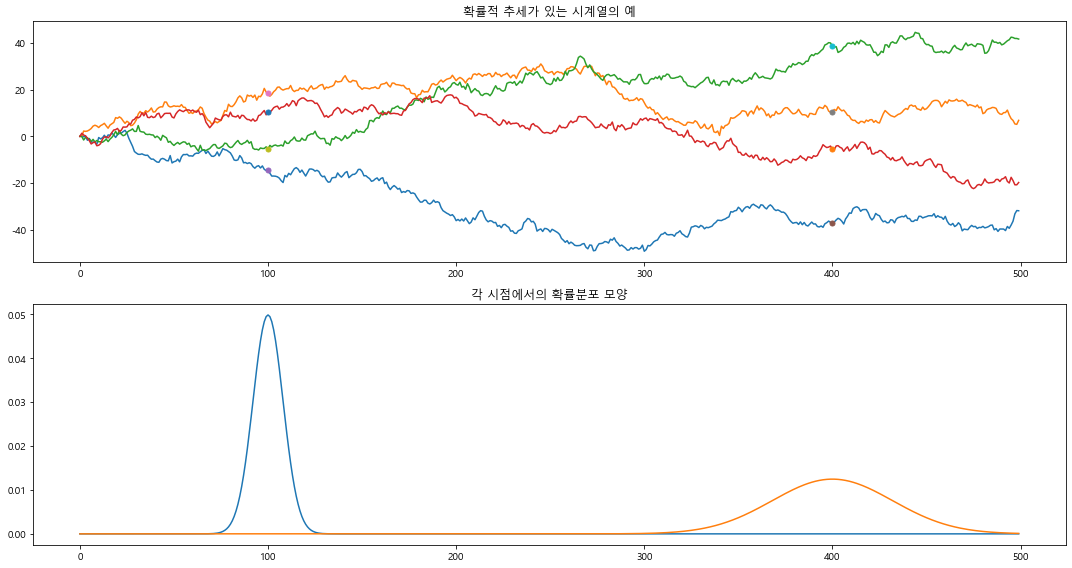

In [20]:
# 다음 시계열 자료들은 동일한 확률 과정의 샘플들이다. 하나 하나의 샘플(시계열 자료)만 보면 마치 추세가 있는 것처럼 보인다.
# 그러나 이는 확률 과정의 분산이 시간 t에 따라 커지기 때문이다. 그래프에 표시하였듯이 t=400에서의 분산은 t=100에서의 분산보다 크다
# 이런 경우 확률적 추세(stochastic trend)를 가진다고 말하기도 한다.

import numpy as np
import scipy as sp
import scipy.stats

N = 500
t1 = 100
t2 = 400
t = np.arange(N)

np.random.seed(12)
y1 = np.insert(np.cumsum(sp.stats.norm.rvs(size=N-1)), 0, 0)
np.random.seed(18)
y2 = np.insert(np.cumsum(sp.stats.norm.rvs(size=N-1)), 0, 0)
np.random.seed(22)
y3 = np.insert(np.cumsum(sp.stats.norm.rvs(size=N-1)), 0, 0)
np.random.seed(24)
y4 = np.insert(np.cumsum(sp.stats.norm.rvs(size=N-1)), 0, 0)

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.title("확률적 추세가 있는 시계열의 예")
plt.plot(t, y1)
plt.plot(t, y2)
plt.plot(t, y3)
plt.plot(t, y4)
plt.plot(t1, y1[t1], 'o', markersize=5)
plt.plot(t2, y1[t2], 'o', markersize=5)
plt.plot(t1, y2[t1], 'o', markersize=5)
plt.plot(t2, y2[t2], 'o', markersize=5)
plt.plot(t1, y3[t1], 'o', markersize=5)
plt.plot(t2, y3[t2], 'o', markersize=5)
plt.plot(t1, y4[t1], 'o', markersize=5)
plt.plot(t2, y4[t2], 'o', markersize=5)

plt.subplot(212)
plt.grid(False)
plt.title("각 시점에서의 확률분포 모양")
plt.plot(t, sp.stats.norm(t1, 0.08*t1).pdf(t))
plt.plot(t, sp.stats.norm(t2, 0.08*t2).pdf(t))

plt.tight_layout()
plt.show()

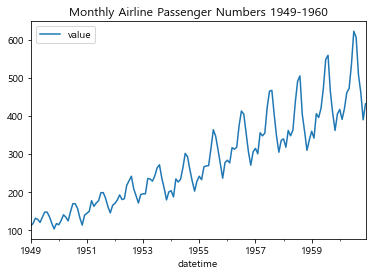

In [21]:
# 로그 변환과 box-cox 변환

# 비정상 확률과정으로 모형화 할 수 있는 시계열 자료 중에서 표준편차가 자료의 크기에 비례하여 증가하는 경향을 보이거나
# 지수함수적으로 증가하는 경향을 보이는 경우에는 로그 변환(logarithm transform)을 해야 한다.

# 다음 시계열 자료는 항공운송인원 데이터이다.
data = sm.datasets.get_rdataset("AirPassengers")
df = data.data

def yearfraction2datetime(yearfraction, startyear=0):
    import datetime
    import dateutil

    year = int(yearfraction) + startyear
    month = int(round(12 * (yearfraction - year)))
    
    delta = dateutil.relativedelta.relativedelta(months=month)
    
    date = datetime.datetime(year, 1, 1) + delta
    return date

df["datetime"] = df.time.map(yearfraction2datetime)
df.plot(x="datetime", y="value")
plt.title(data.title)
plt.show()

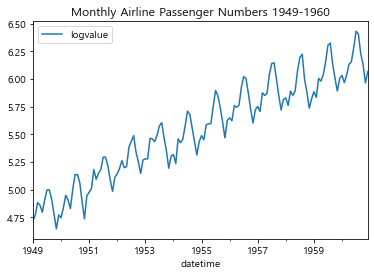

In [22]:
# 값이 상승하며 분산도 증가함을 볼 수 있다. 이 자료를 로그 변환하면 다음과 같다.

df["logvalue"] = np.log(df.value)
df.plot(x="datetime", y="logvalue")
plt.title(data.title)
plt.show()

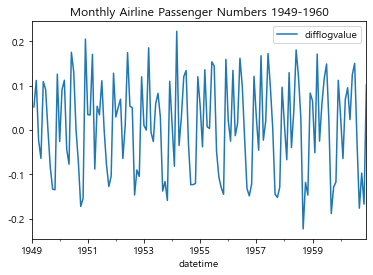

In [23]:
# 여전히 선형 추세는 가지고 있지만 분산의 크기가 비교적 일정하게 변환되었다. 선형 추세를 없애기 위해 이 시계열을 차분한다.
df["difflogvalue"] = df.logvalue.diff()
df.plot(x="datetime", y="difflogvalue")
plt.title(data.title)
plt.show()

# 이제 이 데이터는 정상과정으로 모형화 가능하다.

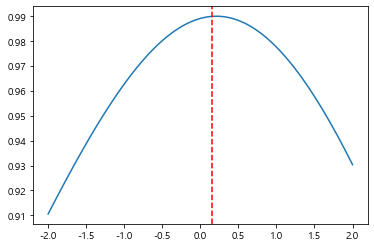

optimal lambda: 0.14802256545004658


In [24]:
# box-cox 변환은 정규분포가 아닌 자료를 정규분포로 변환하기 위해 사용된다. 모수(parameter) 람다를 가진다.

# 보통 여러가지 람다 값을 시도하여 가장 정규성을 높여주는 값을 찾아서 사용한다.

# 최적의 람다 값을 찾기 위해서는 scipy 패키지의 boxcox_normplot 명령과 sp.stats.boxcox 명령을 사용한다.

x, y = sp.stats.boxcox_normplot(df.value, -2, 2)
plt.plot(x, y)
y2, l = sp.stats.boxcox(df.value)
plt.axvline(x=l, color='r', ls="--")
plt.show()
print("optimal lambda:", l)


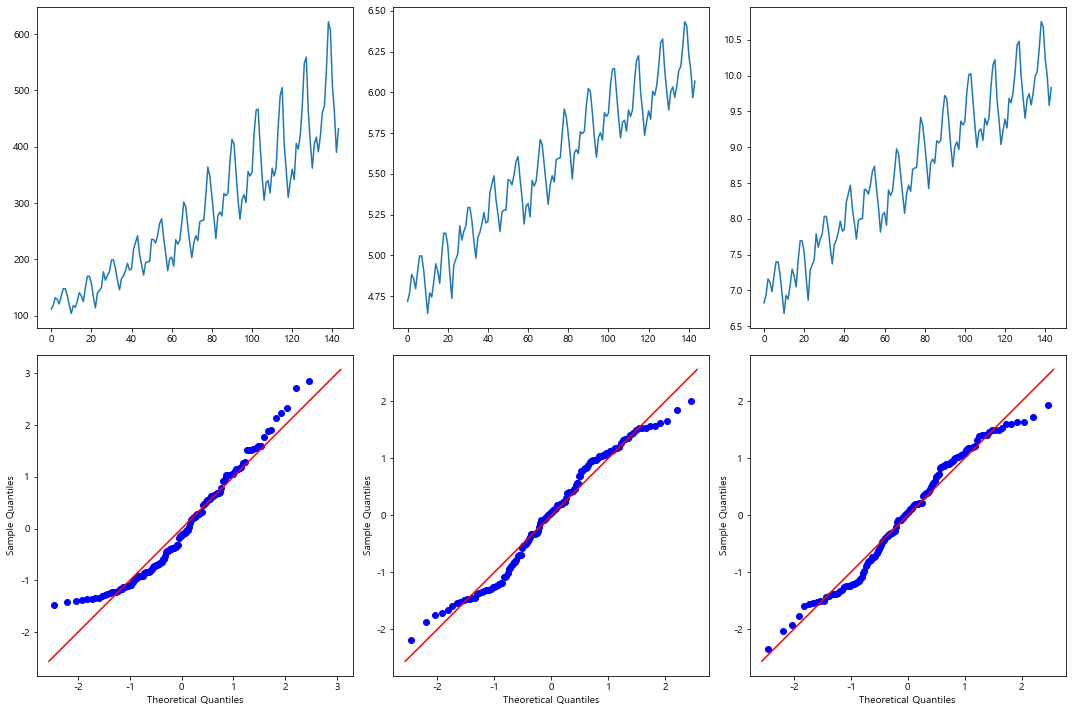

In [26]:
# 정규성을 비교하기 위해 원자료와 Box-Cox 변환 후 차분한 값의 QQ-Plot을 그리면 다음과 같다.
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.plot(df.value)

plt.subplot(232)
plt.plot(np.log(df.value))

plt.subplot(233)
plt.plot(y2)

ax1 = plt.subplot(234)
sm.qqplot(df.value, fit=True, line='45', ax=ax1)
plt.axis("equal")

ax2 = plt.subplot(235)
sm.qqplot(np.diff(np.log(df.value)), fit=True, line='45', ax=ax2)
plt.axis("equal")

ax3 = plt.subplot(236)
sm.qqplot(np.diff(y2), fit=True, line='45', ax=ax3)
plt.axis("equal")

plt.tight_layout()
plt.show()